In [1]:
import json
import torch
import custom_utils
import numpy as np
from sentence_transformers import SentenceTransformer
bert = SentenceTransformer('all-MiniLM-L6-v2')

/Users/czartur/code/course/deep_learning/datachallenge/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read labels
with open("training_labels.json", "r") as json_file:
    labels = json.load(json_file)

# read nodes and edges
dialogs, speakers, edges = custom_utils.gather_dataset("training", combine=False)

In [3]:
# aggregate data from all dialogs
X_train_dialog, y_train, X_train_speaker, train_edge_idx, train_edge_attr = [], [], [], [], []
X_test_dialog, y_test, X_test_speaker, test_edge_idx, test_edge_attr = [], [], [], [], []

count_train, count_test = 0, 0
for id in dialogs.keys():
        if id[0] == 'T': # dumb --> dialogs starting with T for test
                X_test_dialog += dialogs[id]
                X_test_speaker += speakers[id]
                y_test += labels[id]
                test_edge_idx += [[e[0] + count_test, e[2] + count_test] for e in edges[id]]
                test_edge_attr += [e[1] for e in edges[id]]
                count_test += len(labels[id]) 
        else:
                X_train_dialog += dialogs[id]
                X_train_speaker += speakers[id]
                y_train += labels[id]
                train_edge_idx += [[e[0] + count_train, e[2] + count_train] for e in edges[id]]
                train_edge_attr += [e[1] for e in edges[id]]
                count_train += len(labels[id])

In [4]:
# hot encode speakers name
switcher = {
        "PM" : [1,0,0,0],
        "ME" : [0,1,0,0],
        "UI" : [0,0,1,0],
        "ID" : [0,0,0,1]
}

In [5]:
# train formatting
X_dialog = bert.encode(X_train_dialog, show_progress_bar=True, convert_to_tensor=True)
X_speaker = torch.Tensor([switcher[el] for el in X_train_speaker])
X = torch.cat((X_dialog, X_speaker), dim=1)
y = torch.Tensor(y_train).long()
edge_idx = torch.Tensor(train_edge_idx).long().transpose(0,1)
edge_attr = bert.encode(train_edge_attr, show_progress_bar=True, convert_to_tensor=True)

# test formatting
X_test_dialog = bert.encode(X_test_dialog, show_progress_bar=True, convert_to_tensor=True)
X_test_speaker = torch.Tensor([switcher[el] for el in X_test_speaker])
X_test = torch.cat((X_test_dialog, X_test_speaker), dim = 1)
y_test = torch.Tensor(y_test).long()
test_edge_idx = torch.Tensor(test_edge_idx).long().transpose(0,1)
test_edge_attr = bert.encode(test_edge_attr, show_progress_bar=True, convert_to_tensor=True)

Batches: 100%|██████████| 682/682 [00:10<00:00, 64.46it/s]


In [6]:
num_features = X.shape[1]
num_classes = 2
edge_dim = edge_attr.shape[1]

In [7]:
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(num_features, 300)
        self.lin2 = Linear(300, 600)
        self.lin3 = Linear(600, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = x.sigmoid()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        return x

In [28]:
class LSTM(torch.nn.Module):
    def __init__(self, num_features, hidden_size, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        
        self.lstm = torch.nn.LSTM(input_size=num_features, hidden_size=hidden_size, batch_first=True)
        self.lin1 = Linear(hidden_size, 600)
        self.lin2 = Linear(600, num_classes) 

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # output of the last time step
        x = lstm_out[-1, :] # problem at this line...
        
        # linear layer
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.lin2(x)
        return x

In [29]:
from torch_geometric.nn import GATConv, ResGatedGraphConv

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        # self.conv1 = SAGEConv(num_features, hidden_channels)
        # self.conv2 = SAGEConv(hidden_channels, num_classes)
        self.conv1 = ResGatedGraphConv(num_features, hidden_channels, edge_dim=edge_dim)
        self.conv2 = ResGatedGraphConv(hidden_channels, num_classes, edge_dim=edge_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return x

In [30]:
def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(X)  # Perform a single forward pass.
      # out = model(X, edge_idx)  # Perform a single forward pass.
      # out = model(X, edge_idx, edge_attr)  # Perform a single forward pass.
      loss = criterion(out[train_mask], y[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def validate():
      model.eval()
      out = model(X)
      # out = model(X, edge_idx)
      # out = model(X, edge_idx, edge_attr)
      pred = out.argmax(dim=1)  # Use the class with highest probability.

      # TP, FP, FN
      TP = ((pred[val_mask] == 1) & (y[val_mask] == 1)).sum()
      FP = ((pred[val_mask] == 1) & (y[val_mask] == 0)).sum()
      FN = ((pred[val_mask] == 0) & (y[val_mask] == 1)).sum()

      # Calculate precision, recall, and F1 score
      precision = TP / max((TP + FP), 1e-10)  # Avoid division by zero
      recall = TP / max((TP + FN), 1e-10)  # Avoid division by zero
      f1_score = 2 * (precision * recall) / max((precision + recall), 1e-10)  # Avoid division by zero

      # # Calculate accuracy
      # test_correct = pred[val_mask] == y[val_mask]
      # val_acc = int(test_correct.sum()) / int(val_mask.sum())

      return criterion(out[val_mask], y[val_mask]), f1_score

def test():
      model.eval()
      out = model(X_test)
      # out = model(X_test, test_edge_idx)
      # out = model(X_test, test_edge_idx, test_edge_attr)
      pred = out.argmax(dim=1)

      # TP, FP, FN
      TP = ((pred == 1) & (y_test == 1)).sum()
      FP = ((pred == 1) & (y_test == 0)).sum()
      FN = ((pred == 0) & (y_test == 1)).sum()

      # Calculate precision, recall, and F1 score
      precision = TP / max((TP + FP), 1e-10)  # Avoid division by zero
      recall = TP / max((TP + FN), 1e-10)  # Avoid division by zero
      f1_score = 2 * (precision * recall) / max((precision + recall), 1e-10)  # Avoid division by zero
      
      return criterion(out, y_test), f1_score


In [31]:
# model = MLP()
model = LSTM(num_features, 500, num_classes)
# model = GNN(hidden_channels=300)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

In [32]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

# sss = StratifiedShuffleSplit(n_splits=100, random_state=42)
skf = StratifiedKFold(n_splits=5)
all_train_loss, all_val_loss, all_test_loss = [], [], []
for epoch in range(1,201):
    epoch_train_loss = 0
    epoch_val_loss = 0
    epoch_f1_score = 0
    for i, (train_idx, val_idx) in enumerate(skf.split(X,y)):
        train_mask, val_mask = [False]*len(X), [False]*len(X)
        for idx in train_idx: train_mask[idx] = True
        for idx in val_idx: val_mask[idx] = True
        train_mask = torch.Tensor(train_mask).bool()
        val_mask = torch.Tensor(val_mask).bool()
        train_loss = train()
        val_loss, f1_score = validate()

        epoch_train_loss += train_loss.detach().numpy() / skf.get_n_splits()
        epoch_val_loss += val_loss.detach().numpy() / skf.get_n_splits()
        # epoch_f1_score += f1_score.detach().numpy() / skf.get_n_splits() 

    test_loss, f1_score = test()
    all_train_loss.append(epoch_train_loss)
    all_val_loss.append(epoch_val_loss)
    all_test_loss.append(test_loss)
    print(f'Epoch: {epoch:03d}, Train Loss: {epoch_train_loss:.4f}, Val loss: {epoch_val_loss:.4f}, Test loss: {test_loss:.4f}, F1-score: {f1_score:.4f}')

torch.Size([50786, 500])
tensor([[-0.0023,  0.0016,  0.0010,  ...,  0.0061, -0.0025, -0.0217],
        [-0.0012, -0.0033, -0.0006,  ...,  0.0007,  0.0099, -0.0339],
        [-0.0033,  0.0044, -0.0104,  ...,  0.0013,  0.0148, -0.0315],
        ...,
        [ 0.0125, -0.0080, -0.0230,  ..., -0.0156,  0.0079, -0.0107],
        [ 0.0105, -0.0051, -0.0293,  ..., -0.0063,  0.0062, -0.0211],
        [ 0.0051, -0.0010, -0.0306,  ...,  0.0011,  0.0082, -0.0270]],
       grad_fn=<SqueezeBackward1>)


IndexError: The shape of the mask [50786] at index 0 does not match the shape of the indexed tensor [2] at index 0

<function matplotlib.pyplot.show(close=None, block=None)>

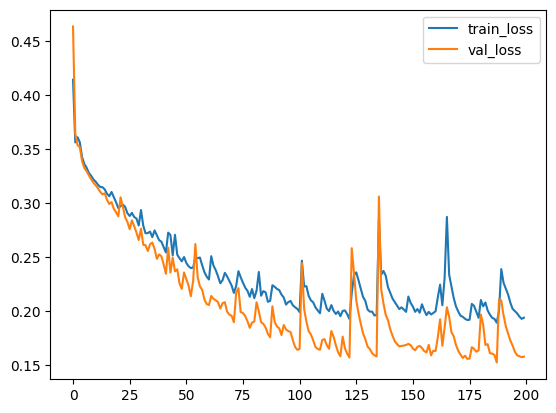

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(all_train_loss, label='train_loss')
plt.plot(all_val_loss,label='val_loss')
plt.legend()
plt.show

In [21]:
test_dialogs, test_speakers, test_edges = custom_utils.gather_dataset("test", combine=False)

test_labels = {}
model.eval()
for id, sentences in test_dialogs.items():
    X_test_dialog = bert.encode(sentences, convert_to_tensor=True)
    X_test_speaker = torch.Tensor([switcher[el] for el in test_speakers[id]])
    X_test = torch.cat((X_test_dialog, X_test_speaker), 1)
    out = model(X_test)
    pred = out.argmax(dim=1)
    test_labels[id] = pred.tolist()

In [22]:
# # uncomment to generate test labels
# with open("test_labels.json", "w") as json_file:
#     json.dump(test_labels, json_file)